In [2]:
import numpy as np
import scipy as sp
import pandas as pd
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# Load the MNIST dataset
mnist = load_digits()

# Access the data and target variables
X = mnist.data
y = mnist.target


## Diversity Sampling

### Random Forest Classifier - Baseline

In [4]:
# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# random forest classifier ohne active learning als Vergleich
baseline_rf = RandomForestClassifier()
baseline_rf.fit(X_train, y_train)

# Genauigkeit auf dem Testdatensatz berechnen
baseline_accuracy = accuracy_score(y_test, baseline_rf.predict(X_test))
print(f'Baseline Accuracy: {baseline_accuracy}')

Baseline Accuracy: 0.975


### Random Forest Classifier - Random Sampling

In [5]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx].reshape(1, -1)

num_runs = 10  # Anzahl der Durchläufe
n_queries = 200  # Anzahl der Abfragezyklen pro Durchlauf
all_performances_random = []  # Hier speichern wir die Ergebnisse jedes Durchlaufs

for run in range(num_runs):
    # Daten neu aufteilen für jeden Durchlauf
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_initial, X_pool, y_initial, y_pool = train_test_split(X_train, y_train, test_size=0.8, random_state=run)

    # Initialisierung des Active Learners mit der Random Sampling Strategie
    random_learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        query_strategy=random_sampling,
        X_training=X_initial, y_training=y_initial
    )

    # Erfassen der anfänglichen Genauigkeit
    performance_history_random = [accuracy_score(y_test, random_learner.predict(X_test))]

    # Durchführung des Active Learning
    for i in range(n_queries):
        query_idx, query_instance = random_learner.query(X_pool)
        random_learner.teach(X_pool[query_idx].reshape(1, -1), y_pool[query_idx].reshape(1))
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        # Berechnung der Genauigkeit nach jedem Query
        model_accuracy = accuracy_score(y_test, random_learner.predict(X_test))
        performance_history_random.append(model_accuracy)

    # Hinzufügen der Leistungsdaten dieses Durchlaufs zur Gesamtliste
    all_performances_random.append(performance_history_random)


In [6]:
# initializing the learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training=X_initial, y_training=y_initial
)

In [7]:
all_performances_with_removal = []
all_performances_without_removal = []

In [8]:

# mit rauslöschen aus dem pool
num_runs = 10  # Anzahl der Durchläufe
n_queries = 200  # Anzahl der Abfragezyklen pro Durchlauf

for run in range(num_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_initial, X_pool, y_initial, y_pool = train_test_split(X_train, y_train, test_size=0.8, random_state=run)

    # Initialisierung des Active Learners
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_initial, y_training=y_initial
    )

    performance_history = [accuracy_score(y_test, learner.predict(X_test))]

    for i in range(n_queries):
        query_idx, _ = learner.query(X_pool)
        if isinstance(query_idx, np.ndarray):
            query_idx = query_idx[0]

        learner.teach(X_pool[query_idx].reshape(1, -1), y_pool[query_idx].reshape(1))

        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        model_accuracy = accuracy_score(y_test, learner.predict(X_test))
        performance_history.append(model_accuracy)

    all_performances_with_removal.append(performance_history)


In [9]:
# ohne raus löschen aus dem pool
num_runs = 10  # Anzahl der Durchläufe
n_queries = 200  # Anzahl der Abfragezyklen pro Durchlauf

for run in range(num_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_initial, X_pool, y_initial, y_pool = train_test_split(X_train, y_train, test_size=0.8, random_state=run)

    # Initialisierung des Active Learners
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_initial, y_training=y_initial
    )

    performance_history = [accuracy_score(y_test, learner.predict(X_test))]

    for i in range(n_queries):
        query_idx, _ = learner.query(X_pool)
        if isinstance(query_idx, np.ndarray):
            query_idx = query_idx[0]

        learner.teach(X_pool[query_idx].reshape(1, -1), y_pool[query_idx].reshape(1))

        model_accuracy = accuracy_score(y_test, learner.predict(X_test))
        performance_history.append(model_accuracy)

    all_performances_without_removal.append(performance_history)


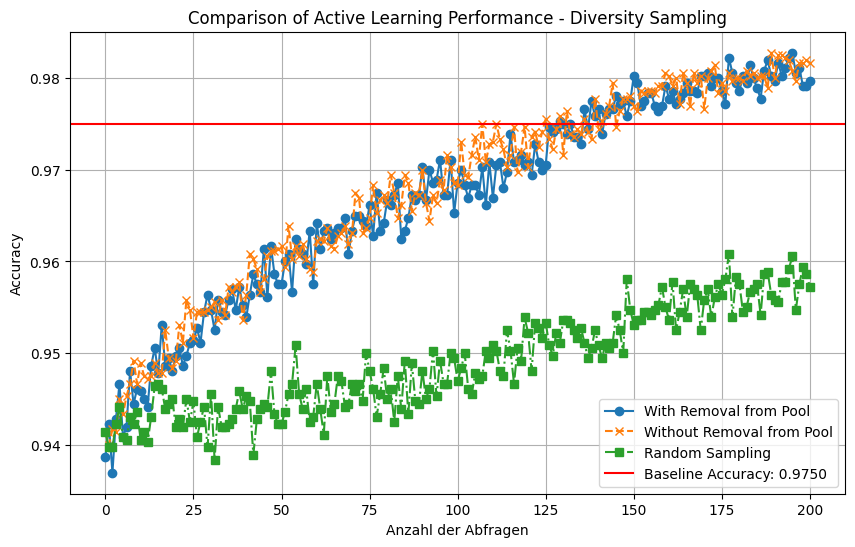

In [10]:
average_performance_with_removal = np.mean(all_performances_with_removal, axis=0)
average_performance_without_removal = np.mean(all_performances_without_removal, axis=0)
average_performance_random = np.mean(all_performances_random, axis=0)

# Erstelle den Plot
plt.figure(figsize=(10, 6))
plt.plot(average_performance_with_removal, label='With Removal from Pool', marker='o', linestyle='-')
plt.plot(average_performance_without_removal, label='Without Removal from Pool', marker='x', linestyle='--')
plt.plot(average_performance_random, label='Random Sampling', marker='s', linestyle='-.')
plt.axhline(y=baseline_accuracy, color='r', linestyle='-', label=f'Baseline Accuracy: {baseline_accuracy:.4f}')
plt.xlabel('Anzahl der Abfragen')
plt.ylabel('Accuracy')
plt.title('Comparison of Active Learning Performance - Diversity Sampling')
plt.grid(True)
plt.legend()
plt.show()


## Uncertainty Sampling

In [11]:
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

In [12]:
num_runs = 10  # Anzahl der Durchläufe
n_queries = 200  # Anzahl der Abfragezyklen pro Durchlauf
all_performances_uncertainty_remove = []
all_performances_uncertainty_keep = []

for run in range(num_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_initial, X_pool, y_initial, y_pool = train_test_split(X_train, y_train, test_size=0.8, random_state=run)

    # Uncertainty Sampling mit Entfernen aus dem Pool
    learner_remove = ActiveLearner(
        estimator=RandomForestClassifier(),
        query_strategy=uncertainty_sampling,
        X_training=X_initial, y_training=y_initial
    )
    performance_history_remove = [accuracy_score(y_test, learner_remove.predict(X_test))]
    for i in range(n_queries):
        query_idx, _ = learner_remove.query(X_pool)
        learner_remove.teach(X_pool[query_idx].reshape(1, -1), y_pool[query_idx].reshape(1))
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = accuracy_score(y_test, learner_remove.predict(X_test))
        performance_history_remove.append(model_accuracy)
    all_performances_uncertainty_remove.append(performance_history_remove)

    # Neuinitialisierung für das Keeping-Szenario
    X_initial, X_pool, y_initial, y_pool = train_test_split(X_train, y_train, test_size=0.5, random_state=run)
    learner_keep = ActiveLearner(
        estimator=RandomForestClassifier(),
        query_strategy=uncertainty_sampling,
        X_training=X_initial, y_training=y_initial
    )
    performance_history_keep = [accuracy_score(y_test, learner_keep.predict(X_test))]
    for i in range(n_queries):
        query_idx, _ = learner_keep.query(X_pool)
        learner_keep.teach(X_pool[query_idx].reshape(1, -1), y_pool[query_idx].reshape(1))
        model_accuracy = accuracy_score(y_test, learner_keep.predict(X_test))
        performance_history_keep.append(model_accuracy)
    all_performances_uncertainty_keep.append(performance_history_keep)


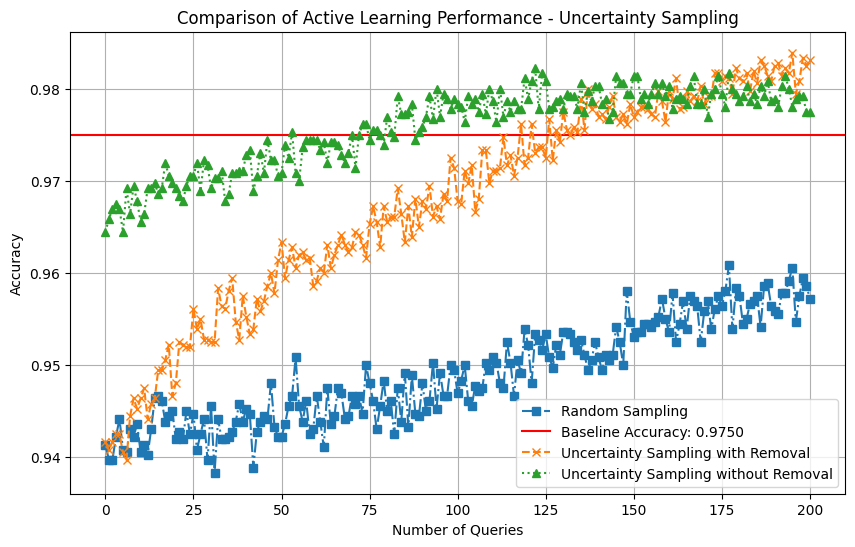

In [13]:
# Plotting the performance comparison
plt.figure(figsize=(10, 6))
plt.plot(average_performance_random, label='Random Sampling', marker='s', linestyle='-.')
plt.axhline(y=baseline_accuracy, color='r', linestyle='-', label=f'Baseline Accuracy: {baseline_accuracy:.4f}')
plt.plot(np.mean(all_performances_uncertainty_remove, axis=0), label='Uncertainty Sampling with Removal', marker='x', linestyle='--')
plt.plot(np.mean(all_performances_uncertainty_keep, axis=0), label='Uncertainty Sampling without Removal', marker='^', linestyle=':')
plt.xlabel('Number of Queries')
plt.ylabel('Accuracy')
plt.title('Comparison of Active Learning Performance - Uncertainty Sampling')
plt.grid(True)
plt.legend()
plt.show()


### Comparing the two directly

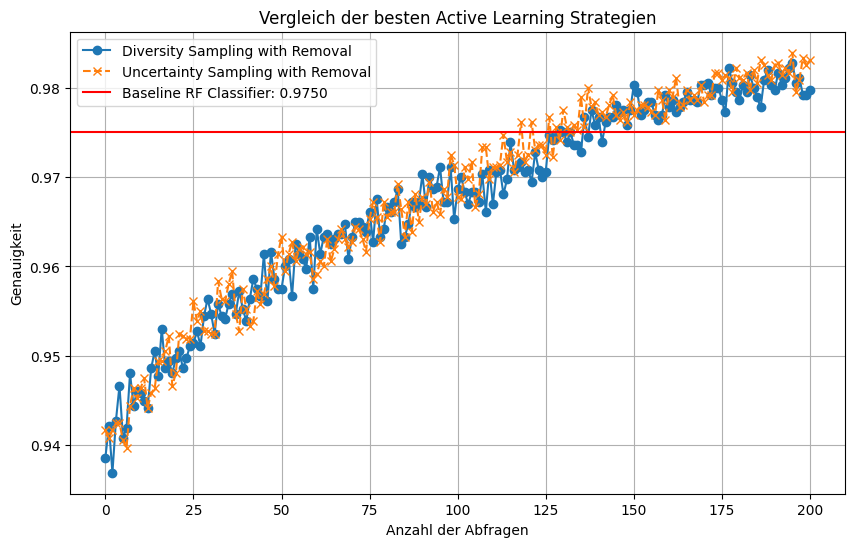

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(average_performance_with_removal, label='Diversity Sampling with Removal', marker='o', linestyle='-')
plt.plot(np.mean(all_performances_uncertainty_remove, axis=0), label='Uncertainty Sampling with Removal', marker='x', linestyle='--')
plt.axhline(y=baseline_accuracy, color='r', linestyle='-', label=f'Baseline RF Classifier: {baseline_accuracy:.4f}')

plt.xlabel('Anzahl der Abfragen')
plt.ylabel('Genauigkeit')
plt.title('Vergleich der besten Active Learning Strategien')
plt.legend()
plt.grid(True)
plt.show()